# Autoencoder Generative Models

## In all Autoencoder applications we aim at extracting essential features of the dataset distribution with the help of some constraints. 

## Usually we use undercomplete layers and bottleneck architecture to enforce smaller expressivity with some additional distruptions to force the network to uncover the real data structure.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Small dataset Fashion MNIST for tests

In [2]:
fashion_mnist=tf.keras.datasets.fashion_mnist.load_data()

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist

In [4]:
X_train, X_test = X_train/255., X_test/255. 

## Basic Stacked Autoencoder

In [ ]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])

stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

In [6]:
stacked_ae.compile(loss="mse", optimizer="nadam")

## Training detail: targets equal to inputs

In [ ]:
history = stacked_ae.fit(X_train, X_train, epochs=4, validation_data=(X_test, X_test), verbose=False)

1/1 [==============================] - 0s 62ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

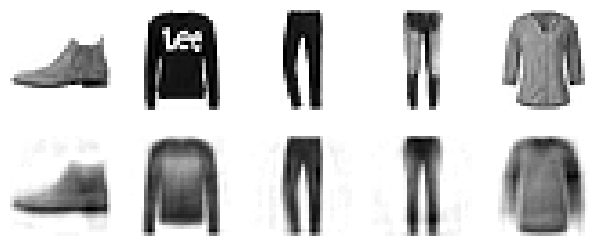

In [8]:
def plot_reconstructions(model, images=X_test, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 255)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
plt.show

## Dimensional reduction and TSNE clustering with Autoencoder

In [9]:
from sklearn.manifold import TSNE

In [10]:
X_valid_compressed = stacked_encoder.predict(X_test)

313/313 [==============================] - 0s 675us/step


In [12]:
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)

In [ ]:
X_valid_2D = tsne.fit_transform(X_valid_compressed)

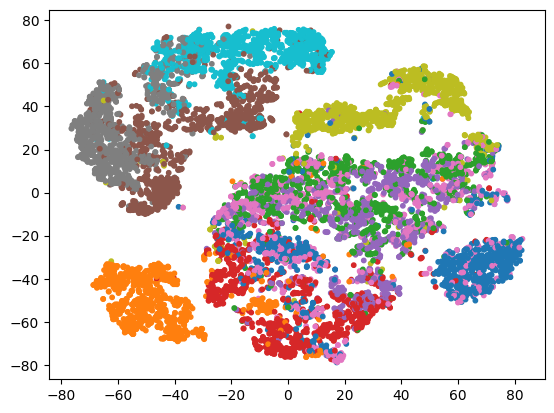

In [18]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_test, s=10, cmap='tab10')

## Weights tying Autoencoder

In [20]:
class DenseTanspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)
                                      

In [21]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

In [23]:
tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTanspose(dense_2, activation="relu"),
    DenseTanspose(dense_1, activation="relu"),
    tf.keras.layers.Reshape([28, 28])
])


In [24]:
tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

In [ ]:
# Training fllows as for the ordinary AE

## Convolutional Autoencoder

In [28]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()
                            ]) # We keep latent space dimension 30


In [61]:
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16), # should in fact be 64 but we reduce parameters cnt
    tf.keras.layers.Reshape([3, 3, 16]),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])


In [63]:
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

In [64]:
conv_ae.compile(loss="mse", optimizer="nadam")

In [65]:
history = conv_ae.fit(X_train, X_train, epochs=8, validation_data=(X_test, X_test), verbose=True)

Epoch 1/8
1875/1875 [==============================] - 12s 5ms/step - loss: 0.0243 - val_loss: 0.0169
Epoch 2/8
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0156 - val_loss: 0.0158
Epoch 3/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0143 - val_loss: 0.0138
Epoch 4/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0135 - val_loss: 0.0131
Epoch 5/8
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 6/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 7/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 8/8
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0120 - val_loss: 0.0124


1/1 [==============================] - 0s 144ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

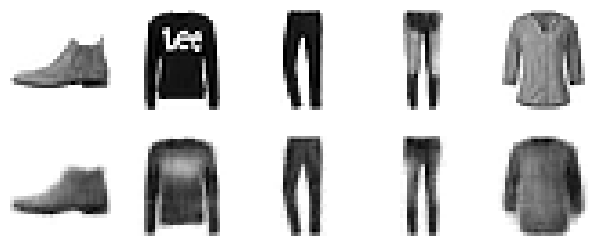

In [66]:
plot_reconstructions(conv_ae)
plt.show

## Decoder Inference from random latent 

In [67]:
def random_dream(decoder, latent, n_images=5):
    
    reconstructions = np.clip(decoder.predict(latent), 0, 255)
    
    
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

In [68]:
img = np.random.randn(5, 30)

## Randomly initialized decoder inference from random latent

1/1 [==============================] - 0s 214ms/step


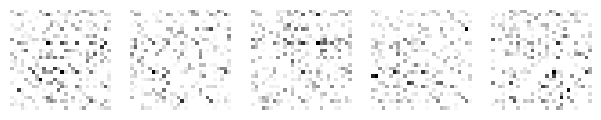

In [62]:
random_dream(conv_decoder, img)

## Trained decoder inference from random latent

1/1 [==============================] - 0s 35ms/step


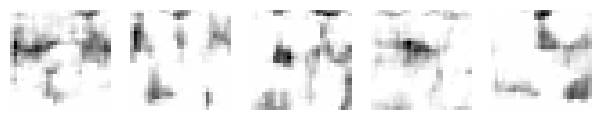

In [69]:
random_dream(conv_decoder, img)

## Denoising Autoencoder

In [76]:
denoise_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    # One version is to use dropout layer
    #tf.keras.layers.Dropout(0.5),
    # Another to add noise
    tf.keras.layers.GaussianNoise(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])

denoise_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

denoise_ae = tf.keras.Sequential([denoise_encoder, denoise_decoder])

In [77]:
denoise_ae.compile(loss="mse", optimizer="nadam")
history = denoise_ae.fit(X_train, X_train, epochs=8, validation_data=(X_test, X_test), verbose=True)

Epoch 1/8
1875/1875 [==============================] - 6s 2ms/step - loss: 0.0296 - val_loss: 0.0221
Epoch 2/8
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0232 - val_loss: 0.0204
Epoch 3/8
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0221 - val_loss: 0.0197
Epoch 4/8
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0215 - val_loss: 0.0192
Epoch 5/8
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0211 - val_loss: 0.0188
Epoch 6/8
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0208 - val_loss: 0.0185
Epoch 7/8
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0205 - val_loss: 0.0181
Epoch 8/8
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0202 - val_loss: 0.0179


1/1 [==============================] - 0s 62ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

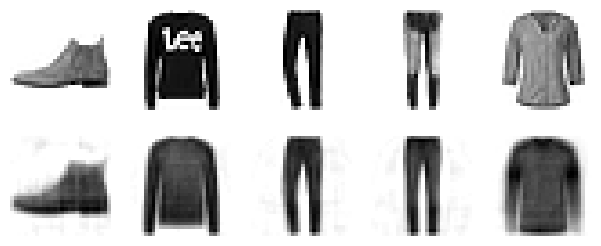

In [78]:
plot_reconstructions(denoise_ae)
plt.show

## Sparse Autoencoders

### Enforeced sparse latent coding

In [79]:
sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    # Alternatively use activity_regularizer=tf.keras.regularizers.l1(1e-4)
    # in the above Dense layer
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])

sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [80]:
sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=8, validation_data=(X_test, X_test), verbose=True)

Epoch 1/8
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0225 - val_loss: 0.0163
Epoch 2/8
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0149 - val_loss: 0.0139
Epoch 3/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 4/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 5/8
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 6/8
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 7/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0111 - val_loss: 0.0118
Epoch 8/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0109 - val_loss: 0.0108


1/1 [==============================] - 0s 60ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

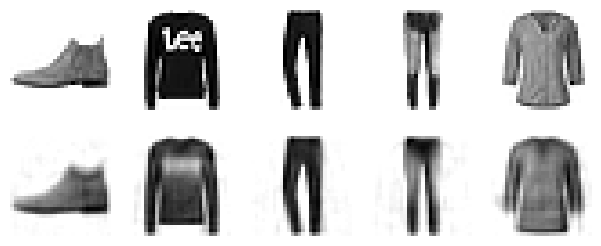

In [81]:
plot_reconstructions(sparse_l1_ae)
plt.show

### KL Divergence regularized layer

In [103]:
q_tab = np.linspace(0.0001 , 0.999,30)

In [104]:
def dkl(p, q):
    return p * np.log(p/q) + (1 - p) * np.log((1-p)/(1-q))

In [105]:
# KL minimum at prescrived binary probablitity 0.2
dkl_tab = dkl(0.2, q_tab)

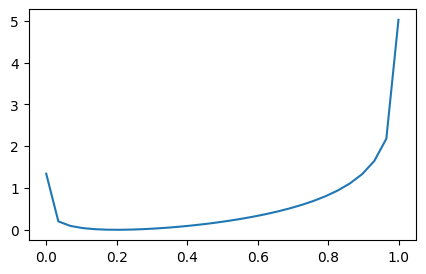

In [106]:
plt.figure(figsize=(5, 3))
plt.plot(q_tab, dkl_tab)

In [107]:
# KL minimum at prescrived binary probablitity 0.2
dkl_tab = dkl(q_tab, 0.2)

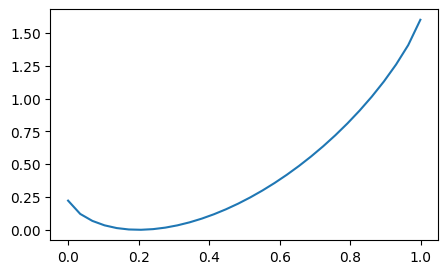

In [108]:
plt.figure(figsize=(5, 3))
plt.plot(q_tab, dkl_tab)

In [109]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

In [110]:
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        # This will give vector of per-neuron activation statistics
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (kl_divergence(self.target, mean_activities) +
                              kl_divergence(1 - self.target, 1 - mean_activities))
        

In [112]:
kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)

In [114]:
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu",
                         activity_regularizer=kld_reg)
])

sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

In [115]:
sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=8, validation_data=(X_test, X_test), verbose=True)

Epoch 1/8
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0205 - val_loss: 0.0144
Epoch 2/8
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 3/8
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 4/8
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 5/8
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 6/8
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 7/8
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 8/8
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0097 - val_loss: 0.0093


1/1 [==============================] - 0s 109ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

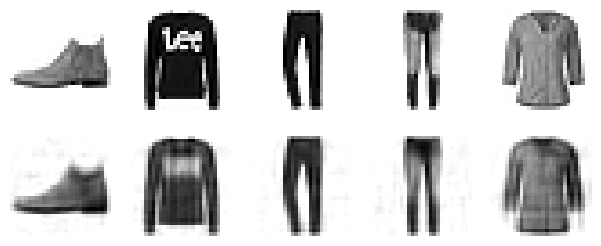

In [116]:
plot_reconstructions(sparse_kl_ae)
plt.show

## VAE

### The latent loss for the mean and std of the latent sampling gaussian
$$ \mathcal{L} = -\frac{1}{2} \sum [ 1 + \gamma_i - e^{\gamma_i} - \mu_i^2 ] $$
$$  \gamma = \text{log}(\sigma^2) $$

In [209]:
# Sampling layer accepting logarithmic sigma and mu
# This log sigma "gamma trick" is for numerical stability 
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [210]:
coding_size = 16

In [211]:
inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(250, activation="relu")(Z)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(coding_size)(Z) # $$\mu$$
codings_log_var = tf.keras.layers.Dense(coding_size)(Z) # $$\log(sigma^2)$$
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [212]:
decoder_inputs = tf.keras.layers.Input(shape=[coding_size])
x = tf.keras.layers.Dense(150, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(250, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28, activation="relu")(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)

variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [213]:
_, _, codings = variational_encoder(inputs)
reconstrucitons = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstrucitons])

In [214]:
latent_loss = - 0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), 
                                   axis=-1)

In [215]:
variational_ae.add_loss(tf.reduce_mean(latent_loss) / (28. * 28.))

In [216]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, 
                             epochs=25, 
                             batch_size=512, # We specify a bit larger batch size so latent statistics is accurate
                             validation_data=(X_test, X_test), verbose=True)

Epoch 1/25
118/118 [==============================] - 2s 5ms/step - loss: 0.0646 - val_loss: 0.0454
Epoch 2/25
118/118 [==============================] - 0s 3ms/step - loss: 0.0419 - val_loss: 0.0394
Epoch 3/25
118/118 [==============================] - 0s 3ms/step - loss: 0.0382 - val_loss: 0.0373
Epoch 4/25
118/118 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0368
Epoch 5/25
118/118 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0359
Epoch 6/25
118/118 [==============================] - 0s 4ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 7/25
118/118 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0346
Epoch 8/25
118/118 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0342
Epoch 9/25
118/118 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0338
Epoch 10/25
118/118 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0337

1/1 [==============================] - 0s 62ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

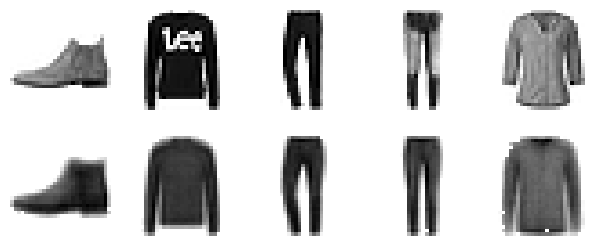

In [217]:
plot_reconstructions(variational_ae)
plt.show

## Generating samples from VAE

In [244]:
codings = tf.random.normal(shape=[3 * 7, coding_size])
images = variational_decoder(codings).numpy()

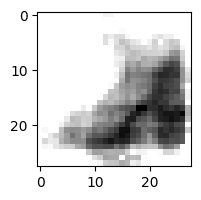

In [247]:
plt.figure(figsize=(4, 2))
plt.imshow(images[2], cmap="binary")

## Semantic interpolation across latent

In [273]:
# Trajectory along 4rth latent dimension
codings = np.zeros([7, coding_size])
codings[:, 5] = np.linspace(-0.8, 0.8, 7)
codings[:, 0] = np.linspace(-0.8, 0.8, 7)
codings[:, 7] = np.linspace(-0.8, 0.8, 7)
codings[:, 15] = np.linspace(-0.8, 0.8, 7)



In [274]:
codings

array([[-0.8       ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.8       ,  0.        , -0.8       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.8       ],
       [-0.53333333,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.53333333,  0.        , -0.53333333,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.53333333],
       [-0.26666667,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.26666667,  0.        , -0.26666667,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.26666667],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.26666667,  0.        ,  0

In [275]:
images = variational_decoder(codings)

In [281]:
tf.reduce_mean(images[0] - images[-1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.0016677694>

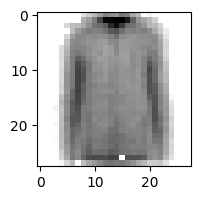

In [282]:
plt.figure(figsize=(4, 2))
plt.imshow(images[0], cmap="binary")

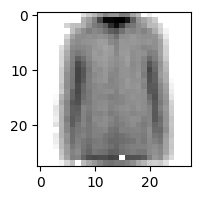

In [283]:
plt.figure(figsize=(4, 2))
plt.imshow(images[6], cmap="binary")